Analysis of price for 5 main features with high feature impact

In [2]:
!pip install pandas==1.3.5

  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1


In [1]:
import io
import boto3
import configparser

import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [2]:
def read_csv_from_s3(section_name, bucket_name, file_path, ):
    
    parser = configparser.ConfigParser()
    parser.read('./config.ini')
    access_key = parser.get(section_name, "access_key")
    secret_key = parser.get(section_name, "secret_key")
    
    s3 = boto3.client('s3',
                      aws_access_key_id=access_key, 
                      aws_secret_access_key=secret_key)
    print("Get object")
    obj = s3.get_object(Bucket=bucket_name, Key=file_path)

    print("Read csv")
    df = pd.read_csv( io.BytesIO( obj["Body"].read() ) )
    
    print("Completed")
    print("Data size:", df.shape)

    return df

In [3]:
section_name = "aws_boto_credentials"
bucket_name = "ev-depreciation-model"
file_path = "220616_used_car_v1.csv"

df = read_csv_from_s3(section_name, bucket_name, file_path)

Get object
Read csv
Completed
Data size: (374526, 18)


In [4]:
cols_num = ["year", "odometer"]
cols_cat = ["manufacturer", "type", "cylinders"]
target = "price"

## 1. numerical - numerical

### 1.1. distribution of numerical features

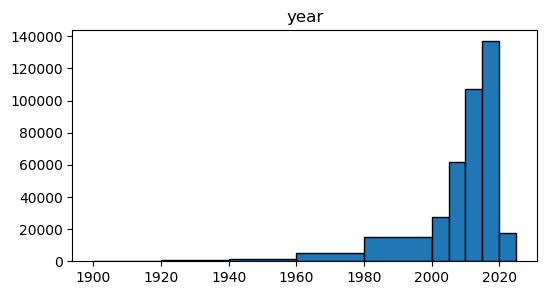

In [5]:
n1 = df[cols_num[0]]
bins1 = [i for i in range(1900, 2000+1, 20)] + [i for i in range(2000, 2025+1, 5)]

plt.figure(figsize=(6,3))
plt.hist(n1, bins=bins1, edgecolor="k")
plt.title(cols_num[0])
plt.show()

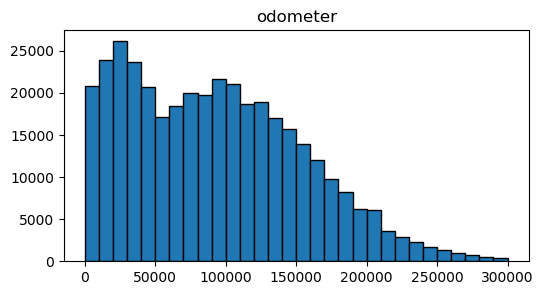

In [6]:
n2 = df[cols_num[1]]
bins2 = [i for i in range(0, 300000+1, 10000)]

plt.figure(figsize=(6,3))
plt.hist(n2, bins=bins2, edgecolor="k")
plt.title(cols_num[1])
plt.show()

### 1.2. binning of numerical features

In [7]:
df[cols_num] = df[cols_num].fillna(-1)

grp_num = pd.DataFrame()
bins = [bins1, bins2]
dicts = []
for c, b in zip(cols_num, bins):
    
    d = {}
    for j in range(len(b)):
        if j==0:
            d[j] = f"(,{b[j]})"
        else:
            d[j] = f"[{b[j-1]},{b[j]})"
    dicts.append(d)
    
    grp_num[f"g_{c}"] = np.digitize(df[c], b)
    grp_num[f"g_{c}"] = grp_num[f"g_{c}"].apply(lambda x: d[x] if x !=0 else '[missing]')

grp_num[target] = df[target].copy()

### 1.3. price heatmap for numerical features

#### Mean (Median) Price for odometer(x) and year(y)

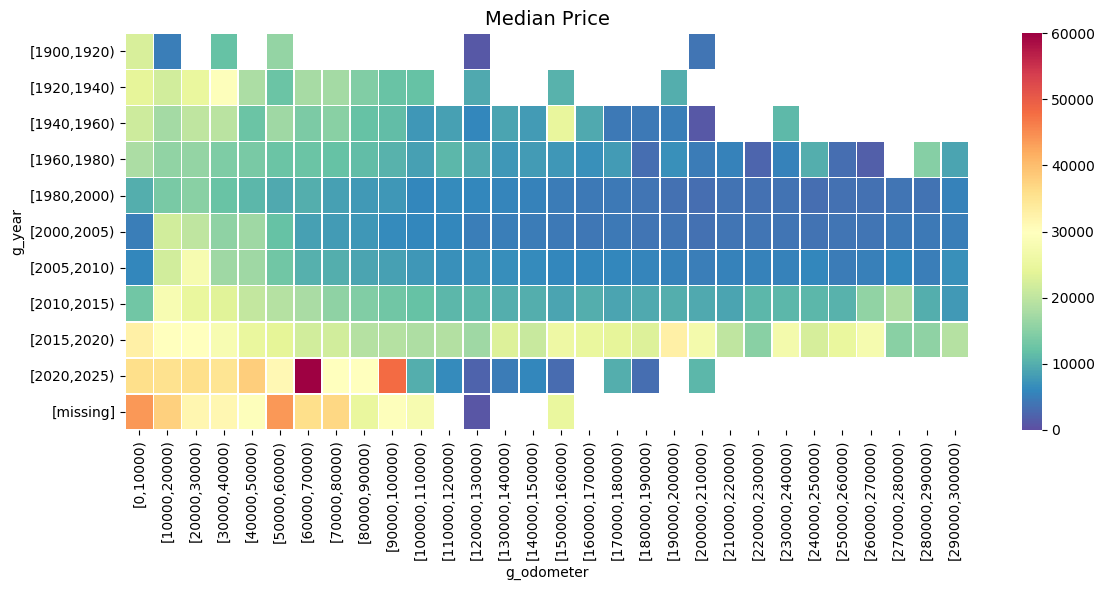

In [8]:
plt_num = grp_num.groupby([f"g_{cols_num[0]}", f"g_{cols_num[1]}"])[target].median().unstack()
order_ = list(dicts[1].values())[1:]
plt_num = plt_num[order_].sort_index()

# heatmap
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.heatmap(plt_num, 
                 vmin=0, vmax=60000, cmap="Spectral_r",
                 linewidths=.5)
plt.title("Median Price", fontsize=14)
plt.tight_layout()
plt.show()

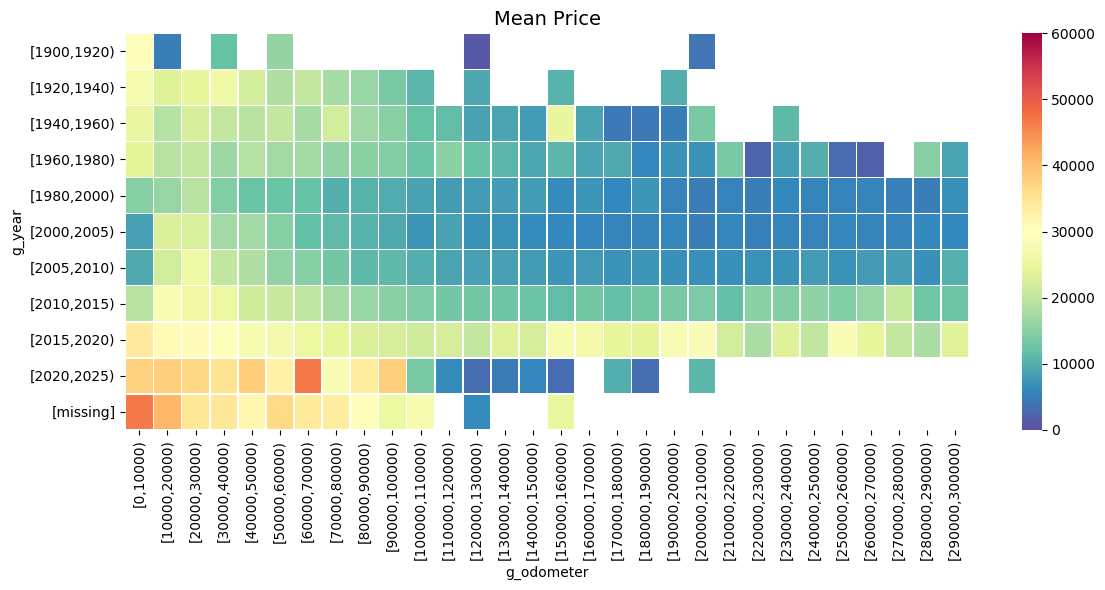

In [9]:
plt_num = grp_num.groupby([f"g_{cols_num[0]}", f"g_{cols_num[1]}"])[target].mean().unstack()
order_ = list(dicts[1].values())[1:]
plt_num = plt_num[order_]

# heatmap
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.heatmap(plt_num, 
                 vmin=0, vmax=60000, cmap="Spectral_r",
                 linewidths=.5)
plt.title("Mean Price", fontsize=14)
plt.tight_layout()
plt.show()

> (year) 최신 차량일수록 (odometer 주행거리가 짧을수록 가격이 상승함  
> (year) 결측값인 경우 상대적으로 높은 가격을 보임  
> 하지만, 2020~2025년 사이, 주행거리 6-70,000, 9-10,000 구간에서 평균 가격이 높게 나타남

## 2. categorical - categorical

### 2.1. distribution of categorical features

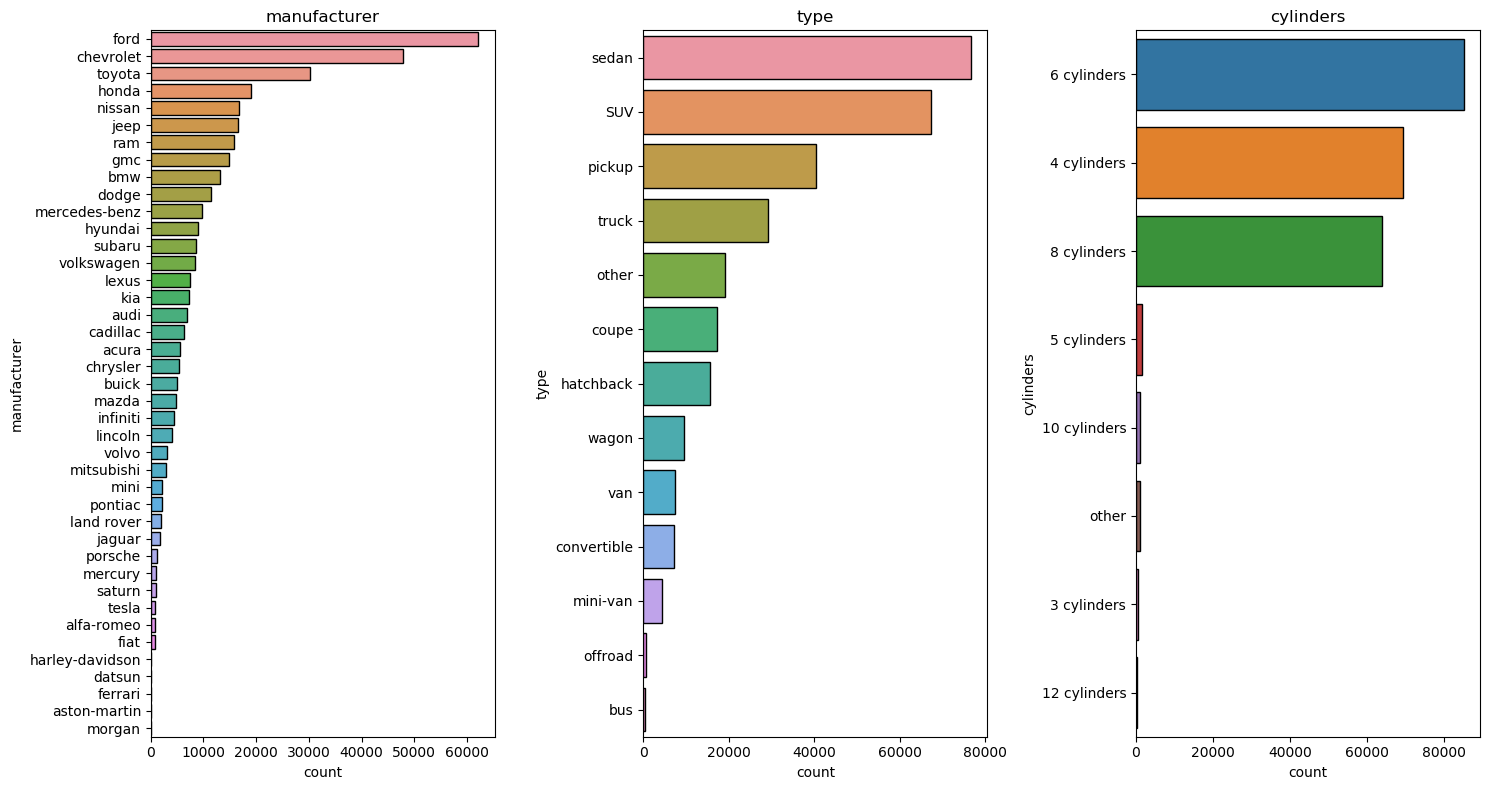

In [10]:
nc = len(cols_cat)
fig, axs = plt.subplots(figsize=(5*nc,8), ncols=nc)

for i, ax in enumerate(axs.flatten()):
    col = cols_cat[i]
    sns.countplot(data=df, y=col,
                  order=df[col].value_counts().index,
                  edgecolor="k", ax=ax)
    ax.set_title(col)
    
plt.tight_layout()
plt.show()

### 2.2. price heatmap for categorical features

In [27]:
df[cols_cat] = df[cols_cat].fillna("miss")

order_cat1 = df.groupby(cols_cat[0])[target].median().sort_values(ascending=False).index.tolist()
order_cat2 = df.groupby(cols_cat[1])[target].median().sort_values(ascending=False).index.tolist()
order_cat3 = [f"{x} cylinders" for x in [3,4,5,6,8,10,12]] + ["other", "miss"]

order_cats = {cols_cat[0]: order_cat1, 
              cols_cat[1]: order_cat2, 
              cols_cat[2]: order_cat3}

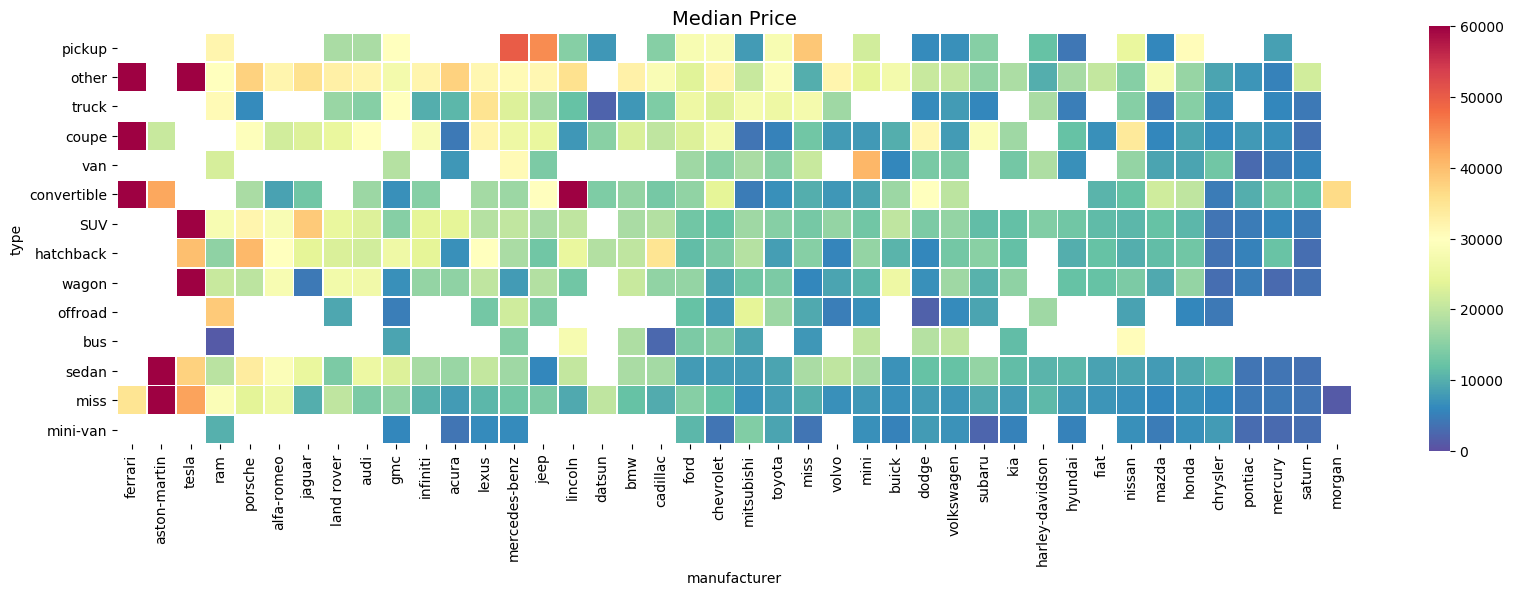

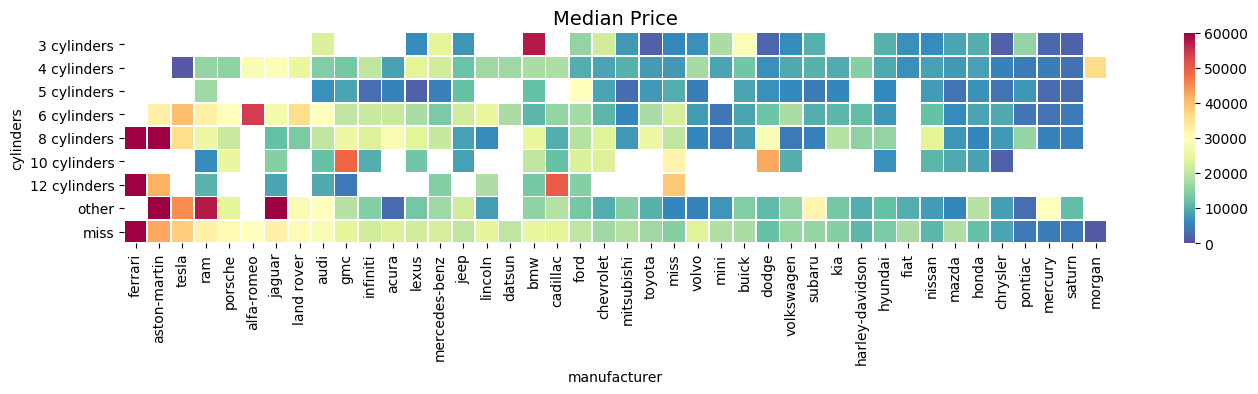

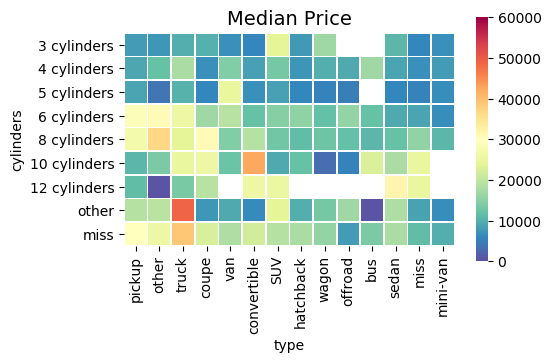

In [28]:
itrs = itertools.combinations(cols_cat, 2)

for itr in itrs:    
    if df[itr[0]].nunique() >= df[itr[1]].nunique():
        c1, c2 = itr[1], itr[0]
        
    else:
        c1, c2 = itr[0], itr[1]
    
    o1, o2 = order_cats[c1], order_cats[c2]
    
    plt_cat = df.groupby([c1, c2])[target].median().unstack()    
    plt_cat = plt_cat.loc[o1, o2]
    
    # heatmap
    w = .4 * df[c2].nunique()
    h = .4 * df[c1].nunique()
    fig, ax = plt.subplots(figsize=(w, h))
    ax = sns.heatmap(plt_cat, 
                     vmin=0, vmax=60000, cmap="Spectral_r",
                     linewidths=.5, square=True)
    plt.title("Median Price", fontsize=14)
    plt.tight_layout()
    plt.show()

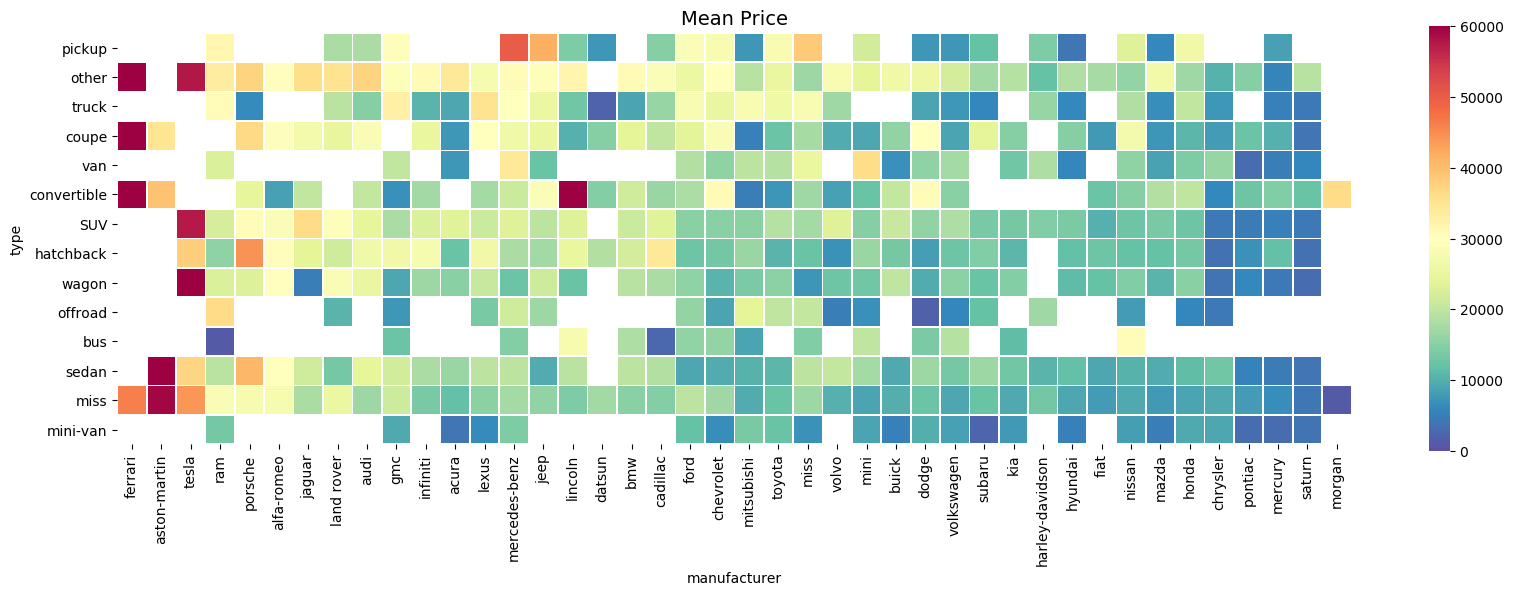

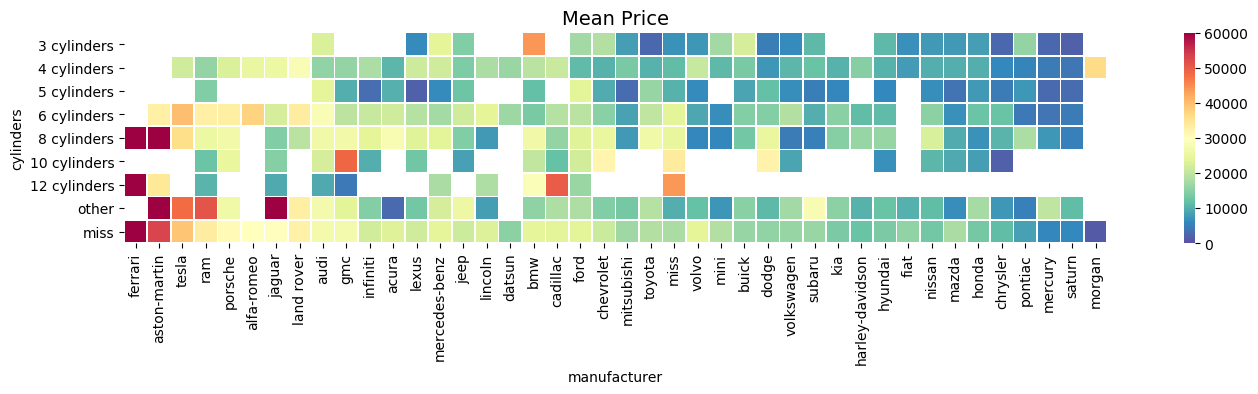

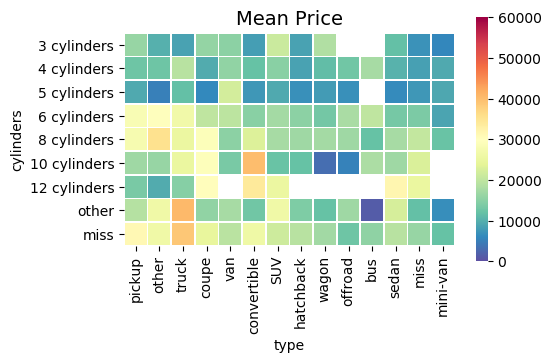

In [29]:
itrs = itertools.combinations(cols_cat, 2)

for itr in itrs:    
    if df[itr[0]].nunique() >= df[itr[1]].nunique():
        c1, c2 = itr[1], itr[0]
    else:
        c1, c2 = itr[0], itr[1]
    
    o1, o2 = order_cats[c1], order_cats[c2]
    
    plt_cat = df.groupby([c1, c2])[target].mean().unstack()    
    plt_cat = plt_cat.loc[o1, o2]

    # heatmap
    w = .4 * df[c2].nunique()
    h = .4 * df[c1].nunique()
    fig, ax = plt.subplots(figsize=(w, h))
    ax = sns.heatmap(plt_cat, 
                     vmin=0, vmax=60000, cmap="Spectral_r",
                     linewidths=.5, square=True)
    plt.title("Mean Price", fontsize=14)
    plt.tight_layout()
    plt.show()

> 제조사가 (manufacturer) ferrari, aston_martin, tesla의 경우 차종(type)과 실린더 개수(cylinders)에 상관없이 높은 가격대를 형성함  
> 기타 (manufacturer-type) lincoln-convertible, benz-pickup의 평균 가격이 높음  
> 기타 (manufacturer-cylinders) jaguar/ram-other cylinder, cadillac/miss-12 cylinders, bmw-3 cylinders의 평균 가격이 높음 

> 실린더 개수(cylinders)는 많을수록 가격이 높은 경향이 있음  
> 차종(type)은 pickup/other/truck/coupe/van 순으로 비교적 크기가 클수록 높은 가격을 보이지만 버스의 경우 가격이 상대적으로 낮음

## 3. categorical - numerical

### 3.1. price heatmap for numerical and categorical feature

In [31]:
grp = grp_num.copy()
grp[cols_cat] = df[cols_cat].copy()

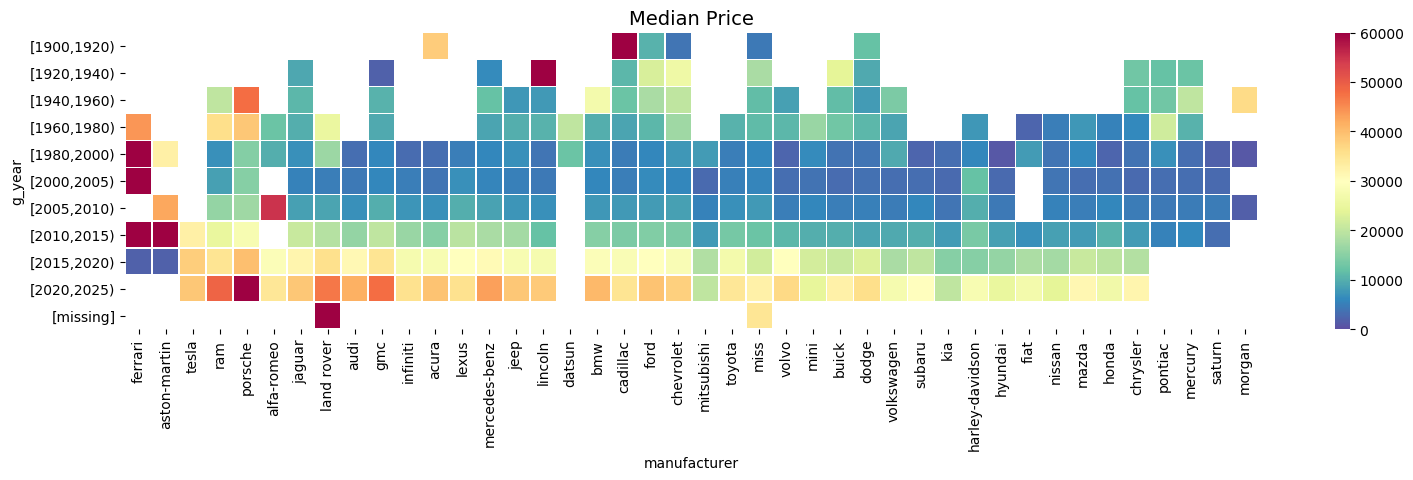

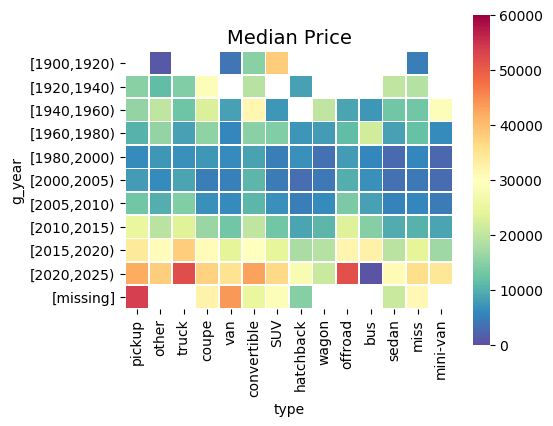

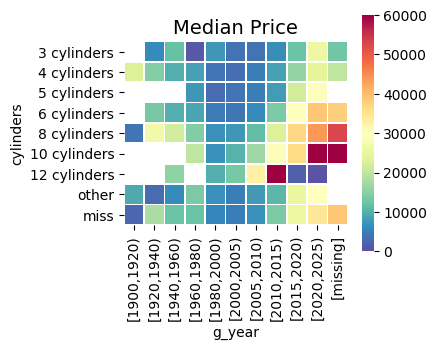

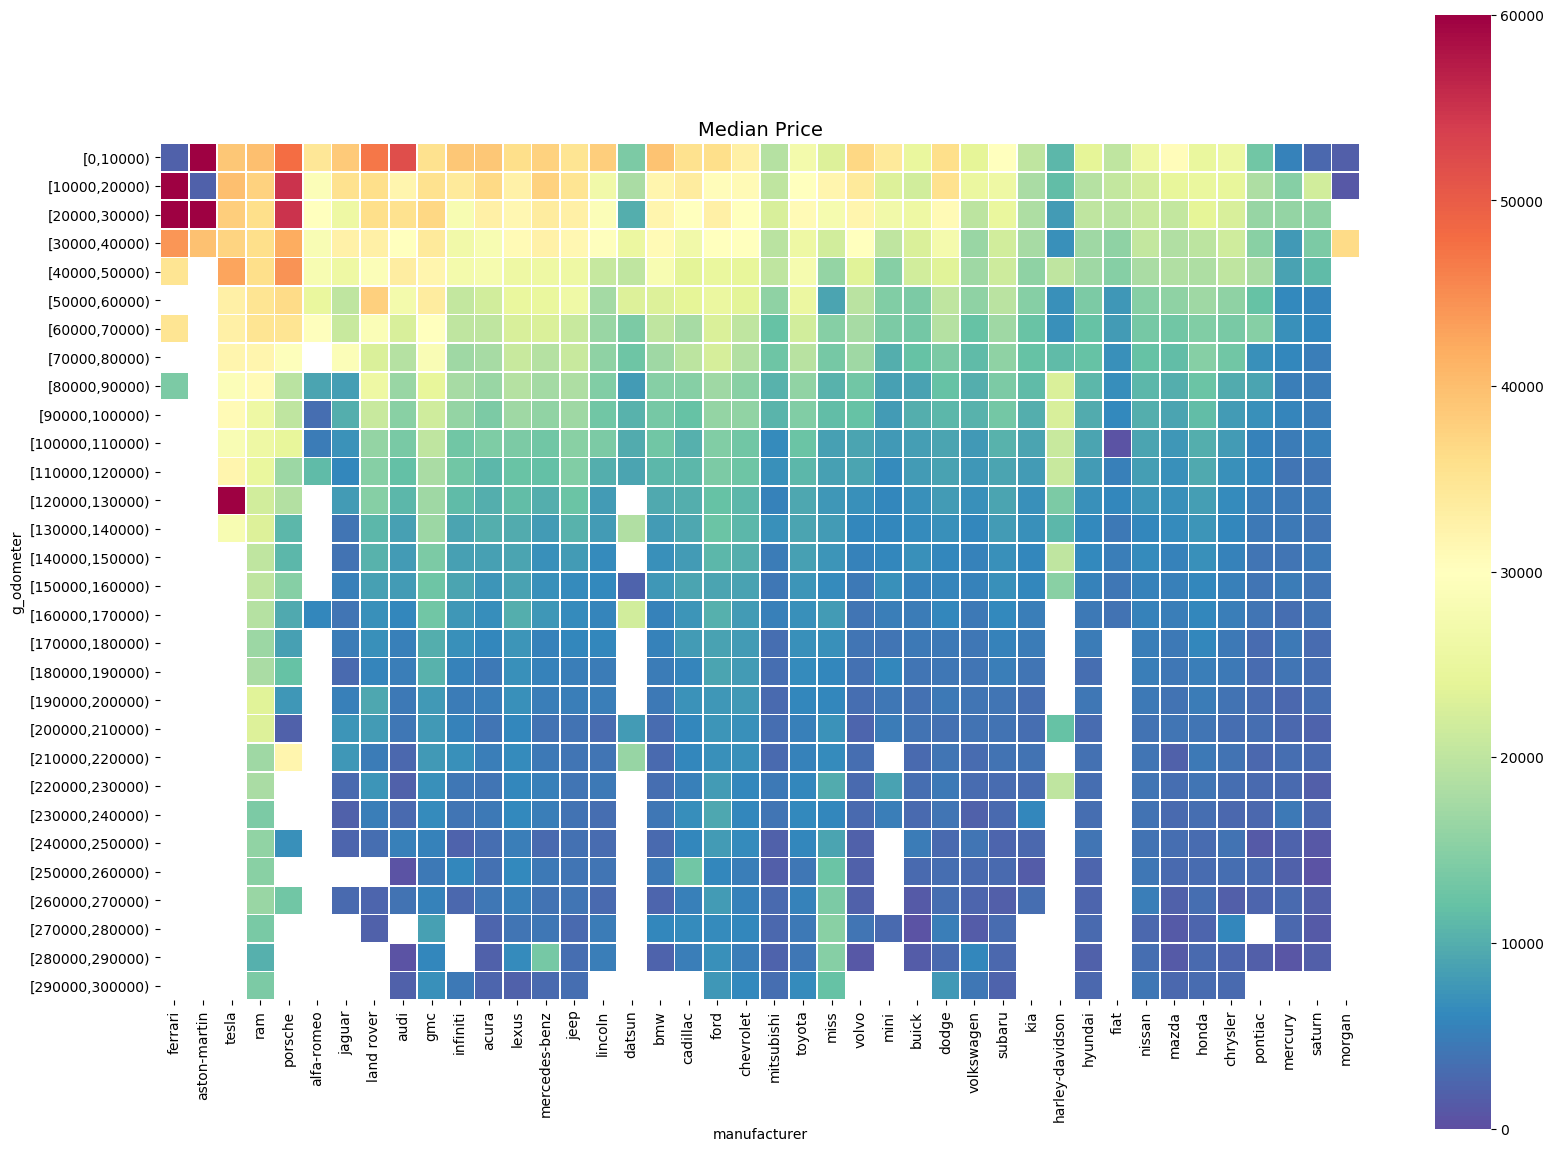

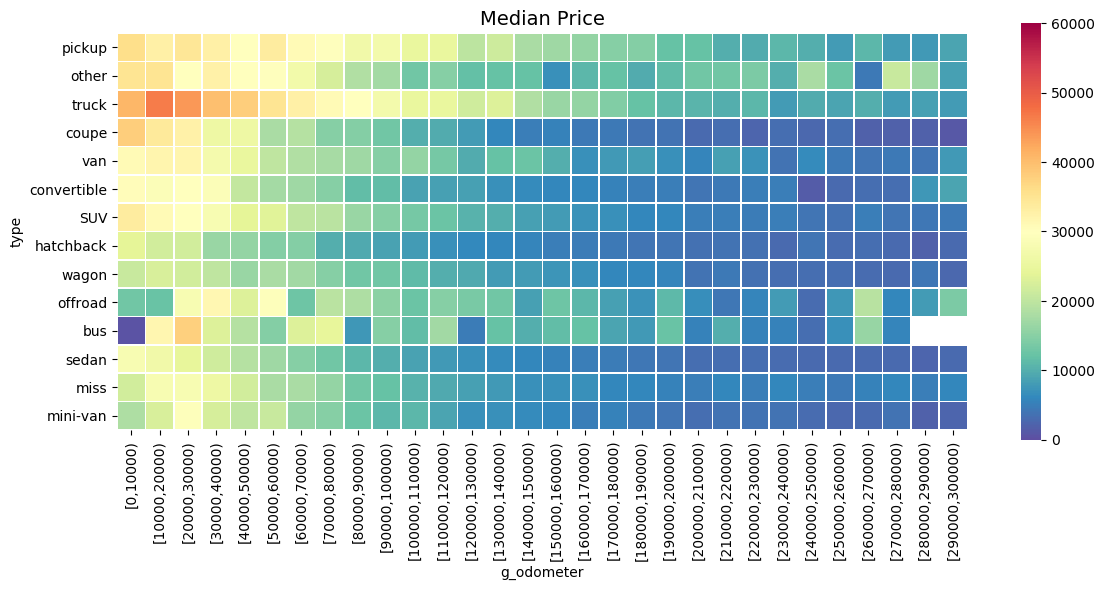

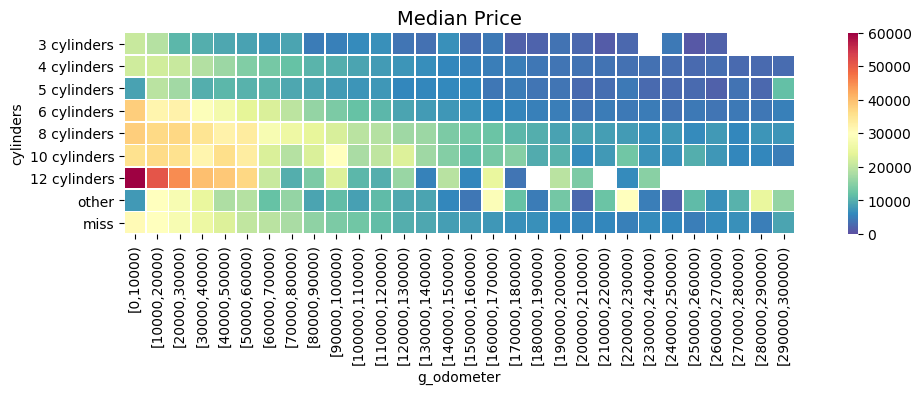

In [34]:
for x1 in [f"g_{s}" for s in cols_num]:
    for x2 in cols_cat:
        
        if grp[x1].nunique() >= grp[x2].nunique():
            c1, c2 = x2, x1
        else:
            c1, c2 = x1, x2
   
        plt_ = grp.groupby([c1, c2])[target].median().unstack()
    
        if 'odometer' in c1:
            plt_ = plt_.loc[order_, order_cats[c2]]
        elif 'odometer' in c2:
            plt_ = plt_.loc[order_cats[c1], order_]
        elif c1 in cols_cat:
            plt_ = plt_.loc[order_cats[c1], :]
        else:
            plt_ = plt_.loc[:, order_cats[c2]]
            
        # heatmap
        w = .4 * grp[c2].nunique()
        h = .4 * grp[c1].nunique()
        fig, ax = plt.subplots(figsize=(w, h))
        ax = sns.heatmap(plt_, 
                         vmin=0, vmax=60000, cmap="Spectral_r",
                         linewidths=.5, square=True)
        plt.title("Median Price", fontsize=14)
        plt.tight_layout()
        plt.show()

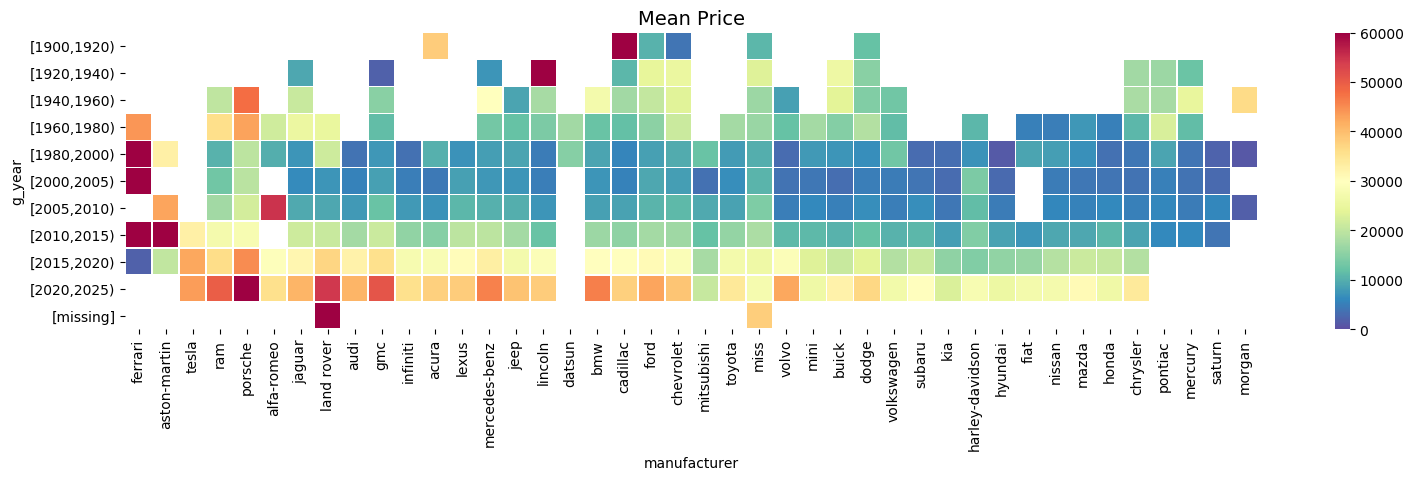

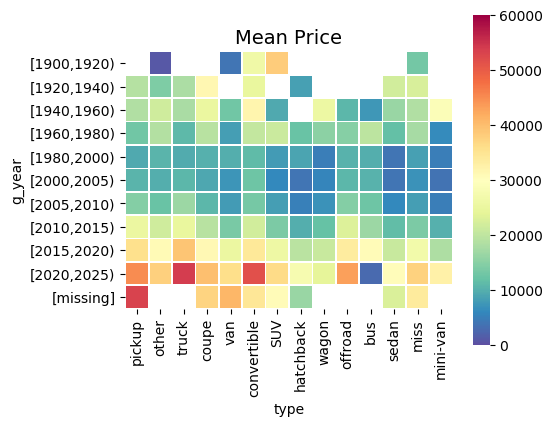

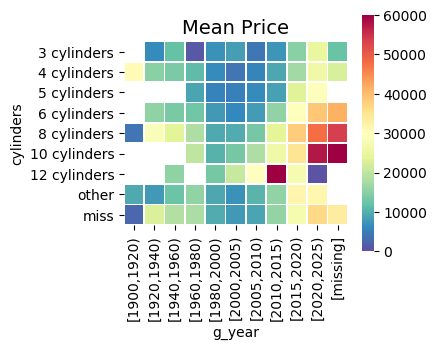

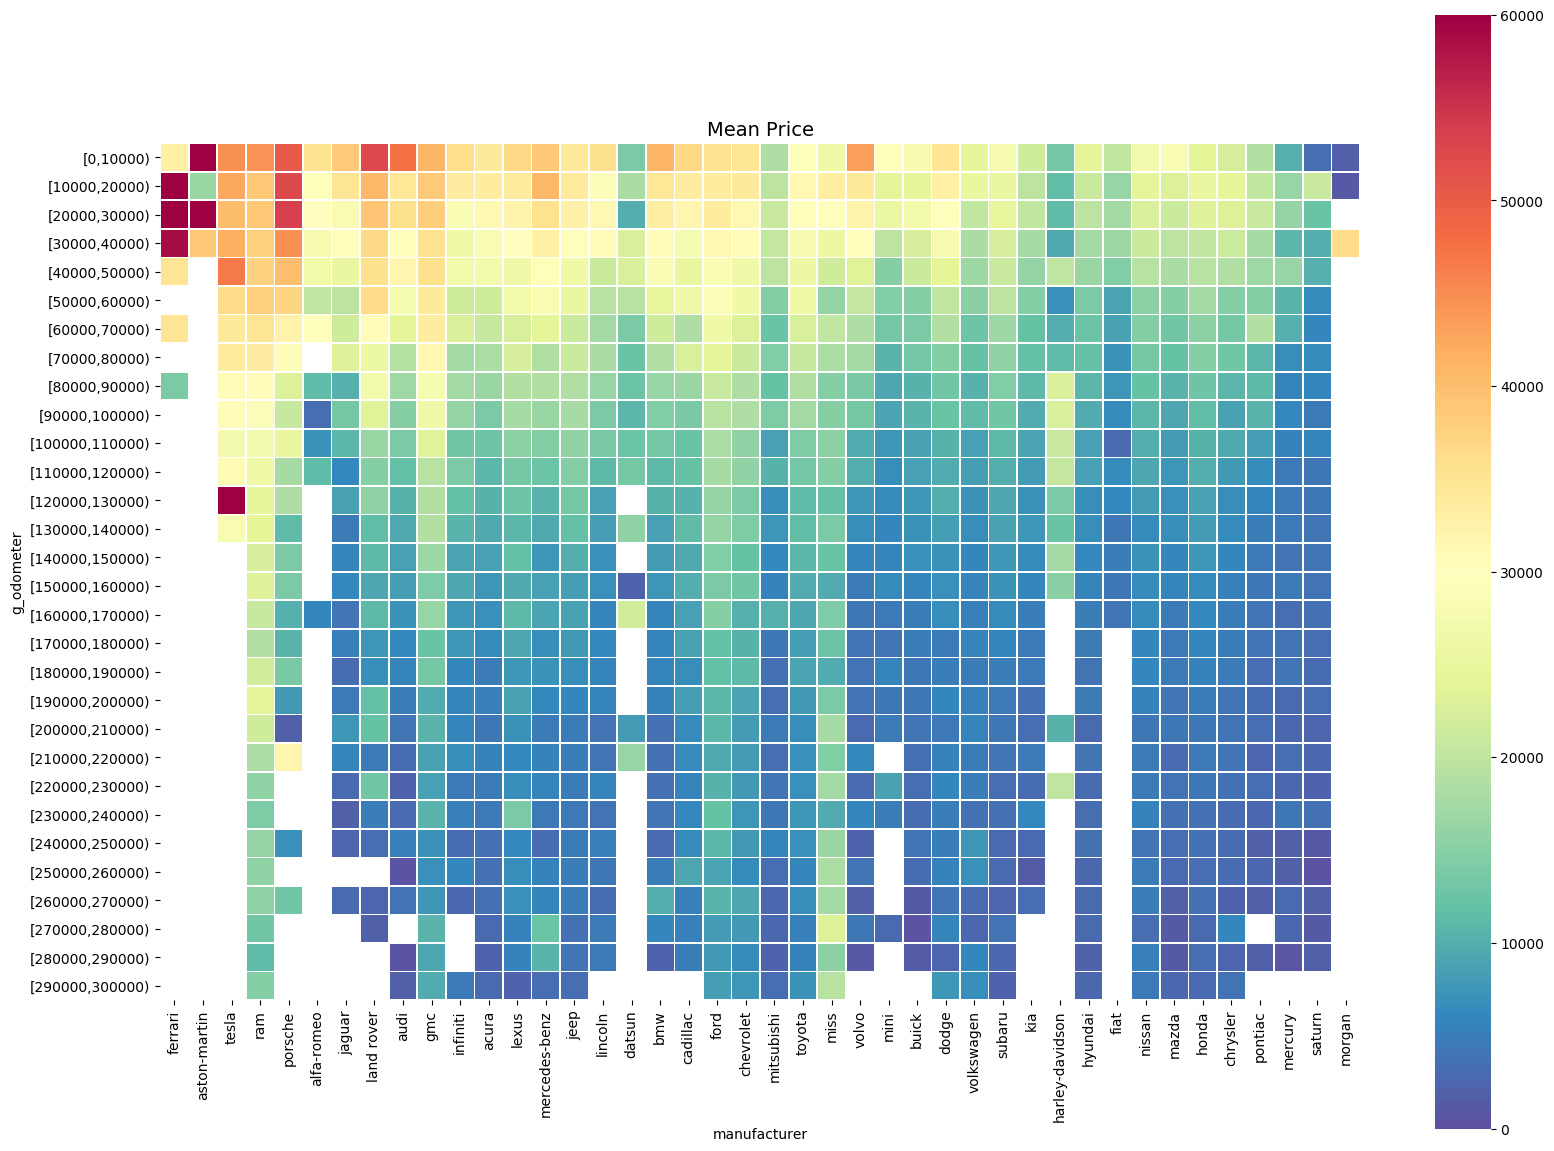

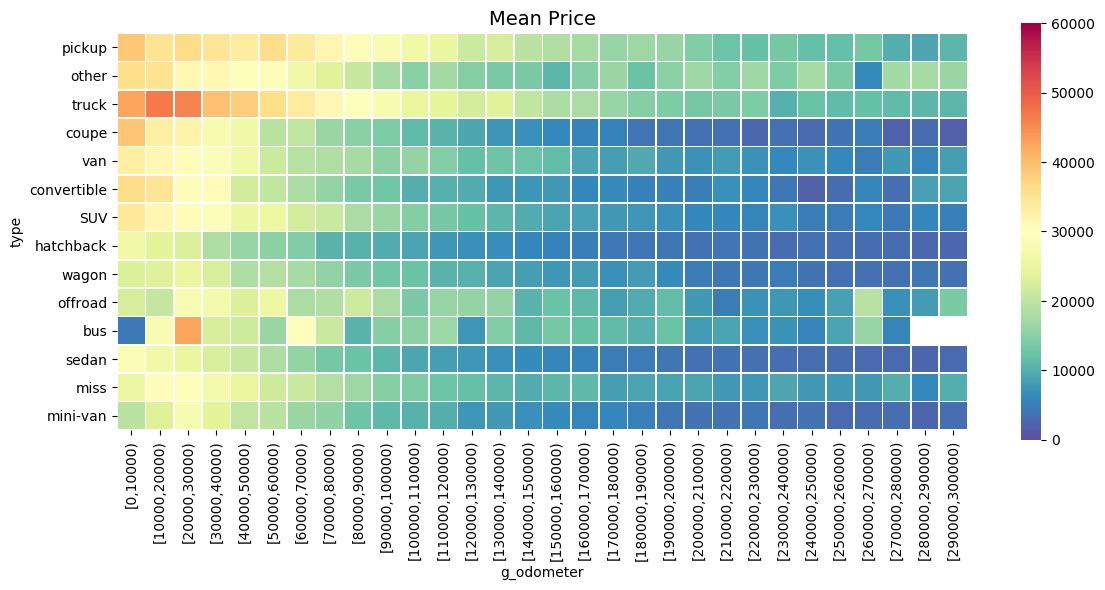

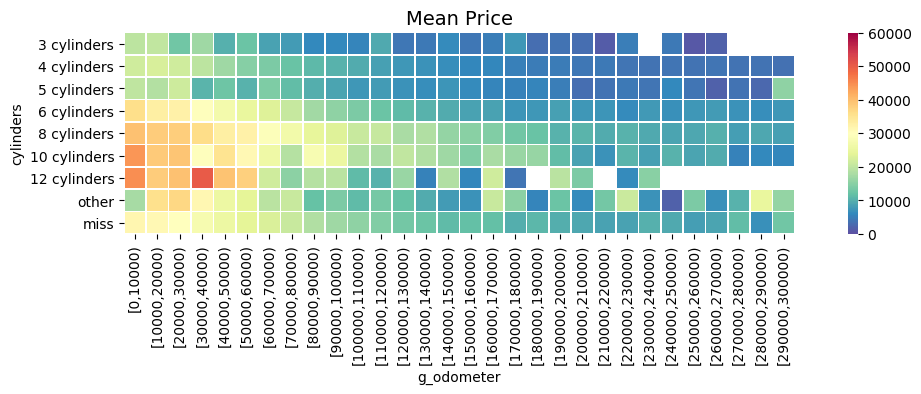

In [36]:
for x1 in [f"g_{s}" for s in cols_num]:
    for x2 in cols_cat:
        
        if grp[x1].nunique() >= grp[x2].nunique():
            c1, c2 = x2, x1
        else:
            c1, c2 = x1, x2
   
        plt_ = grp.groupby([c1, c2])[target].mean().unstack()

        if 'odometer' in c1:
            plt_ = plt_.loc[order_, order_cats[c2]]
        elif 'odometer' in c2:
            plt_ = plt_.loc[order_cats[c1], order_]
        elif c1 in cols_cat:
            plt_ = plt_.loc[order_cats[c1], :]
        else:
            plt_ = plt_.loc[:, order_cats[c2]]
            
        # heatmap
        w = .4 * grp[c2].nunique()
        h = .4 * grp[c1].nunique()
        fig, ax = plt.subplots(figsize=(w, h))
        ax = sns.heatmap(plt_, 
                         vmin=0, vmax=60000, cmap="Spectral_r",
                         linewidths=.5, square=True)
        plt.title("Mean Price", fontsize=14)
        plt.tight_layout()
        plt.show()

> 차량연도(year)가 최신일수록 가격이 상승하는 경향이 있지만, 1980년 이전차량은 오히려 높은 가격으로 거래되는 경우가 있음 (특히, lincoln, caldilac)  
> 주행거리(odometer)가 증가할수록 차량 가격이 감소하는 것이 일반적이지만, tesla의 경우 주행거리가 120,000임에도 평균 가격이 높았음 (확인 필요)  
> 차종(bus)의 경우 낮은 주행거리 10,000에서 낮은 가격대를 보이는데, 주행거리가 0으로 데이터 수집에 문제가 있는 것으로 예상됨 (확인 필요)